In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.optimize import differential_evolution
import random
import math
from deap import base, creator, tools, algorithms
# from cec2005.functions import *

Part 1: Fuzzy Logic Controller (FLC) Design and Implementation

FLC Output: -2.1684043449710086e-17


d:\PythonInstallation\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


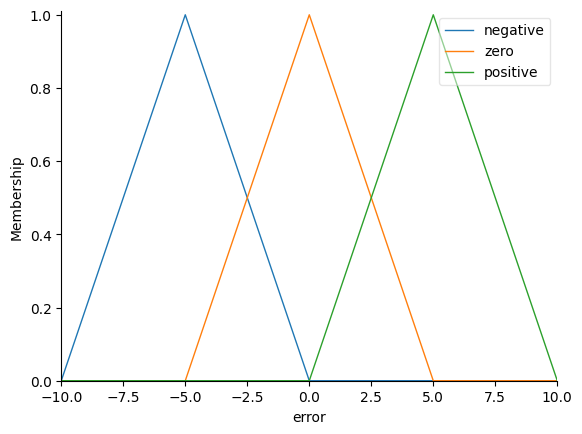

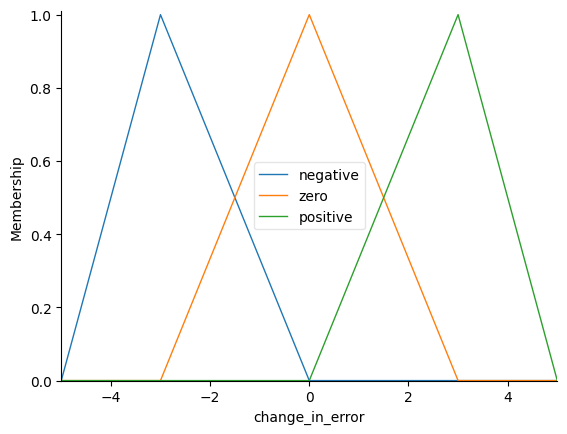

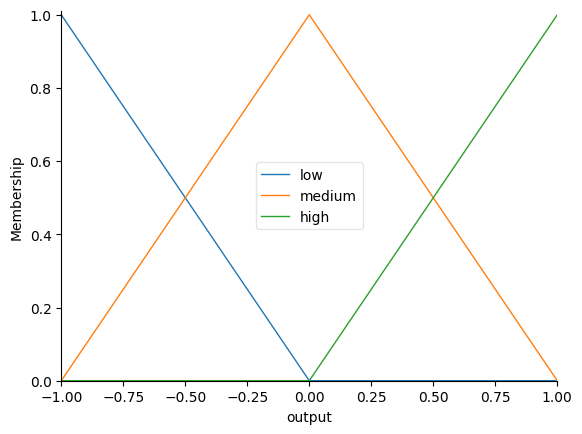

In [2]:
# Define input variables
error = ctrl.Antecedent(np.arange(-10, 11, 1), 'error')
change_in_error = ctrl.Antecedent(np.arange(-5, 6, 1), 'change_in_error')

# Define output variable
output = ctrl.Consequent(np.arange(-1, 2, 1), 'output')

# Define membership functions for input variables
error['negative'] = fuzz.trimf(error.universe, [-10, -5, 0])
error['zero'] = fuzz.trimf(error.universe, [-5, 0, 5])
error['positive'] = fuzz.trimf(error.universe, [0, 5, 10])

change_in_error['negative'] = fuzz.trimf(change_in_error.universe, [-5, -3, 0])
change_in_error['zero'] = fuzz.trimf(change_in_error.universe, [-3, 0, 3])
change_in_error['positive'] = fuzz.trimf(change_in_error.universe, [0, 3, 5])

# Define membership functions for output variable
output['low'] = fuzz.trimf(output.universe, [-1, -1, 0])
output['medium'] = fuzz.trimf(output.universe, [-1, 0, 1])
output['high'] = fuzz.trimf(output.universe, [0, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(error['negative'] & change_in_error['negative'], output['low'])
rule2 = ctrl.Rule(error['zero'] | change_in_error['zero'], output['medium'])
rule3 = ctrl.Rule(error['positive'] & change_in_error['positive'], output['high'])

# Create fuzzy control system
flc_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
flc = ctrl.ControlSystemSimulation(flc_ctrl)

# Sample input values
flc.input['error'] = -3
flc.input['change_in_error'] = 2

# Compute FLC output
flc.compute()

# Print FLC output
print("FLC Output:", flc.output['output'])

# Visualize membership functions
error.view()
change_in_error.view()
output.view()
plt.show()

# Part 2: FLC Optimization using Genetic Algorithm #

Input Values: error : -9.91241443259884
change_in_error : 1.629570076212996

Antecedents Membership Function Values:
negative: -0.30780313747014776
zero: -0.1762406083370045
positive: 0.0929896426434671
negative: -0.03335077935396491
zero: -0.6252167604033594
positive: -0.8055552990673702
Consequents Membership Function Values:
low: 0.093941147747022
medium: 0.6008170207629591
high: 0.8391102661585228
Dimensions - x: (3,) xmf: () value: ()
Input Values: error : 9.862578572365312
change_in_error : 3.538529176142422

Antecedents Membership Function Values:
negative: -0.30780313747014776
zero: -0.1762406083370045
positive: 0.0929896426434671
negative: -0.03335077935396491
zero: -0.6252167604033594
positive: -0.8055552990673702
Consequents Membership Function Values:
low: 0.093941147747022
medium: 0.6008170207629591
high: 0.8391102661585228
Dimensions - x: (3,) xmf: () value: ()
Input Values: error : 5.9247227207498305
change_in_error : 0.8971388253072714

Antecedents Membership Function V

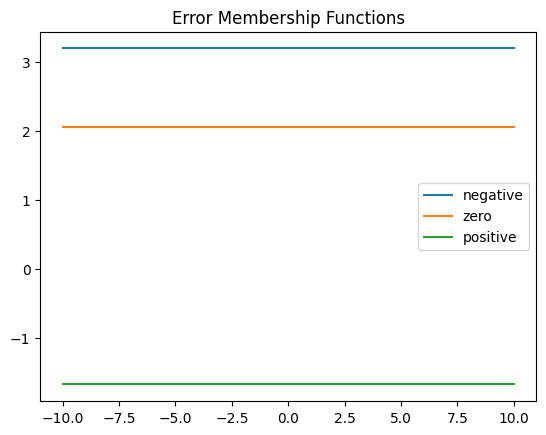

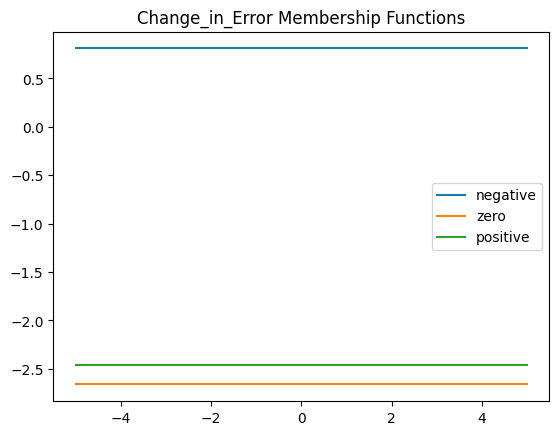

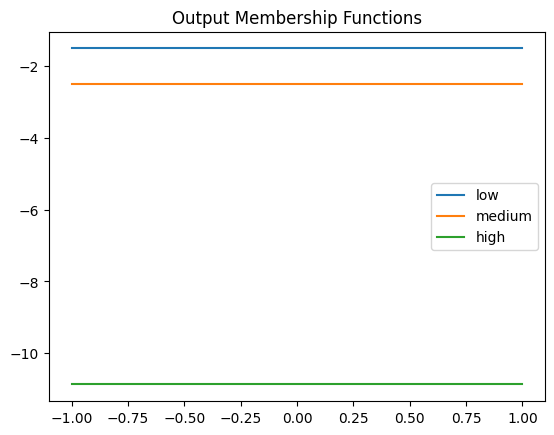

In [3]:
# Define the problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

# Number of parameters to optimize (length of chromosome)
num_params = len(error.terms.values()) + len(change_in_error.terms.values()) + len(output.terms.values())

# Initialize the genetic algorithm parameters
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, num_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the mate, mutate, and select functions
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def evaluate_fitness(params):
    try:
        # Update membership functions with the parameters
        update_membership_functions(params)
    except Exception as e:
        print("Error during membership function update:", e)
        print("Params:", params)
        raise e

    # Initialize the fuzzy control system simulation
    local_flc_ctrl = ctrl.ControlSystemSimulation(flc_ctrl)

    # Initialize variables for simulation
    num_samples = 100
    temperature_setpoint = 25  # Desired room temperature
    temperature_deviation_sum = 0

    # Simulate the FLC over multiple samples
    for _ in range(num_samples):
        try:
            # Generate random error and change_in_error values for simulation
            local_flc_ctrl.input['error'] = np.float64(random.uniform(-10, 10))
            local_flc_ctrl.input['change_in_error'] = np.float64(random.uniform(-5, 5))

            
            print("Input Values:", local_flc_ctrl.input)

            
            print("Antecedents Membership Function Values:")
            for antecedent in local_flc_ctrl.ctrl.antecedents:
                for term_name, term in antecedent.terms.items():
                    print(f"{term_name}: {term.mf}")

            print("Consequents Membership Function Values:")
            for consequent in local_flc_ctrl.ctrl.consequents:
                for term_name, term in consequent.terms.items():
                    print(f"{term_name}: {term.mf}")

            # Ensure that the universe values and input values have compatible dimensions
            for antecedent in local_flc_ctrl.ctrl.antecedents:
                x = antecedent.universe
                term = antecedent.terms[next(iter(antecedent.terms))]
                xmf = term.mf
                # Use the index to access the corresponding parameter in the params array
                index = list(error.terms.keys()).index(next(key for key, value in error.terms.items() if value is term))
                value = params[index]
                print("Dimensions - x:", x.shape, "xmf:", xmf.shape, "value:", value.shape)

            # Compute FLC output
            local_flc_ctrl.compute()
        except ValueError as ve:
            print("Error during FLC computation:", ve)
            print("Input Values:", local_flc_ctrl.input)
            print("Error Universe:", error.universe)
            print("Change_in_error Universe:", change_in_error.universe)
            print("Output Universe:", output.universe)
            raise ve

        
        print("Output Value:", local_flc_ctrl.output['output'])

        # Get the simulated output and calculate temperature deviation
        simulated_output = local_flc_ctrl.output['output']
        temperature_deviation = abs(simulated_output - temperature_setpoint)
        temperature_deviation_sum += temperature_deviation

    # Calculate the average temperature deviation as the fitness
    average_temperature_deviation = temperature_deviation_sum / num_samples

    return average_temperature_deviation,

def update_membership_functions(params):
    # Extract parameters and update membership functions accordingly
    num_error_terms = len(error.terms)
    num_change_in_error_terms = len(change_in_error.terms)
    num_output_terms = len(output.terms)

    # Extract parameters for error membership functions
    error_params = params[:num_error_terms]
    for i, term in enumerate(error.terms.values()):
        term.mf = error_params[i]

    # Extract parameters for change_in_error membership functions
    change_in_error_params = params[num_error_terms:num_error_terms + num_change_in_error_terms]
    for i, term in enumerate(change_in_error.terms.values()):
        term.mf = change_in_error_params[i]

    # Extract parameters for output membership functions
    output_params = params[num_error_terms + num_change_in_error_terms:]
    for i, term in enumerate(output.terms.values()):
        term.mf = output_params[i]

    # Ensure that the universe values are consistent with the updated membership functions
    error.universe = np.linspace(-10, 10, len(error.terms.values()))  
    change_in_error.universe = np.linspace(-5, 5, len(change_in_error.terms.values()))  
    output.universe = np.linspace(-1, 1, len(output.terms.values()))  


toolbox.register("evaluate", evaluate_fitness)

# Main genetic algorithm loop
def main():
    population_size = 50
    generations = 20

    # Create an initial population
    population = toolbox.population(n=population_size)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Crossover and mutate for specified generations
    for generation in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Use the registered mate and mutate functions here
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            toolbox.mate(child1, child2)
            toolbox.mutate(child1)
            toolbox.mutate(child2)

        # Selection using tournament selection
        population = toolbox.select(offspring + population, k=population_size)

    # Get the best individual after the genetic algorithm optimization
    best_ind = tools.selBest(population, k=1)[0]

    print("Best Individual's Parameters:", best_ind)
    update_membership_functions(best_ind)

    # Manually plot membership functions
    plot_membership_functions(error, "Error Membership Functions")
    plot_membership_functions(change_in_error, "Change_in_Error Membership Functions")
    plot_membership_functions(output, "Output Membership Functions")

    plt.show()

def plot_membership_functions(variable, title):
    plt.figure()
    for name, term in variable.terms.items():
        membership_values = [term.mf for _ in variable.universe]
        plt.plot(variable.universe, membership_values, label=name)
    plt.title(title)
    plt.legend()
    plt.show()


# Run the optimization
if __name__ == "__main__":
    main()

# Part 3: Benchmark Function Optimization #

Running Genetic Algorithm on rastrigin with 2 dimensions...
gen	nevals
0  	0     
1  	47    
2  	47    
3  	46    
4  	45    
5  	48    
6  	42    
7  	44    
8  	43    
9  	48    
10 	44    
11 	43    
12 	47    
13 	43    
14 	43    
15 	46    
16 	45    
17 	48    
18 	45    
19 	49    
20 	43    
21 	46    
22 	40    
23 	44    
24 	45    
25 	45    
26 	46    
27 	44    
28 	43    
29 	42    
30 	44    
31 	45    
32 	42    
33 	49    
34 	45    
35 	47    
36 	50    
37 	48    
38 	46    
39 	48    
40 	49    
41 	44    
42 	45    
43 	44    
44 	44    
45 	44    
46 	45    
47 	48    
48 	43    
49 	48    
50 	46    
51 	48    
52 	41    
53 	46    
54 	46    
55 	43    
56 	45    
57 	43    
58 	45    
59 	43    
60 	43    
61 	48    
62 	43    
63 	44    
64 	48    
65 	42    
66 	45    
67 	48    
68 	43    
69 	48    
70 	45    
71 	42    
72 	45    
73 	48    
74 	44    
75 	46    
76 	48    
77 	45    
78 	47    
79 	43    
80 	45    
81 	48    
82 	47    
83 	47    
84 	4

d:\PythonInstallation\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\PythonInstallation\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


84 	45    
85 	47    
86 	46    
87 	45    
88 	46    
89 	45    
90 	44    
91 	44    
92 	46    
93 	46    
94 	46    
95 	48    
96 	45    
97 	41    
98 	47    
99 	41    
100	40    
gen	nevals
0  	0     
1  	45    
2  	47    
3  	40    
4  	45    
5  	46    
6  	43    
7  	48    
8  	44    
9  	42    
10 	44    
11 	47    
12 	45    
13 	44    
14 	45    
15 	46    
16 	46    
17 	42    
18 	44    
19 	44    
20 	43    
21 	48    
22 	45    
23 	44    
24 	43    
25 	45    
26 	42    
27 	46    
28 	45    
29 	45    
30 	47    
31 	46    
32 	44    
33 	43    
34 	43    
35 	40    
36 	46    
37 	49    
38 	48    
39 	44    
40 	45    
41 	47    
42 	47    
43 	47    
44 	43    
45 	46    
46 	47    
47 	45    
48 	42    
49 	44    
50 	45    
51 	48    
52 	47    
53 	48    
54 	44    
55 	46    
56 	45    
57 	47    
58 	46    
59 	43    
60 	46    
61 	46    
62 	43    
63 	48    
64 	48    
65 	45    
66 	46    
67 	43    
68 	46    
69 	43    
70 	45    
71 	44    
72 	46    

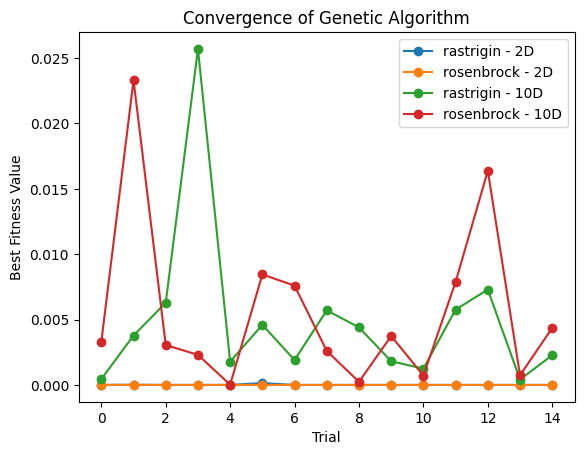

In [4]:
# Ensure reproducibility
random.seed(42)

# Benchmark Functions
def rastrigin(individual):
    return sum(x**2 - 10 * math.cos(2 * math.pi * x) + 10 for x in individual),

def rosenbrock(individual):
    return sum(100.0*(individual[i+1]-individual[i]**2)**2 + (1-individual[i])**2 for i in range(len(individual)-1)),

# Genetic Algorithm Setup
def create_individual(dim):
    return creator.Individual([random.uniform(-5.12, 5.12) for _ in range(dim)])

def evaluate(individual):
    return sum(x**2 for x in individual),

def genetic_algorithm(dim, function, generations=100, population_size=50, cxpb=0.7, mutpb=0.2):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("individual", create_individual, dim=dim)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Fitness attribute should be a tuple
    toolbox.decorate("evaluate", tools.DeltaPenalty(evaluate, (0,), 0.1))

    population = toolbox.population(n=population_size)

    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    try:
        algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, cxpb=cxpb, mutpb=mutpb, ngen=generations, stats=None, halloffame=None, verbose=True)
    except KeyboardInterrupt:
        pass  # Gracefully handle keyboard interrupt

    # Return the best individual
    return tools.selBest(population, k=1)[0]

# Multiple Trials
def run_trials(dim, function, num_trials=15):
    best_results = []
    for _ in range(num_trials):
        best_individual = genetic_algorithm(dim, function)
        best_results.append(best_individual.fitness.values[0])
    return best_results

# Visualization
# def plot_convergence(results):
#     plt.plot(results, marker='o')
#     plt.xlabel('Trial')
#     plt.ylabel('Best Fitness Value')
#     plt.title('Convergence of Genetic Algorithm')
#     plt.show()

def plot_convergence(results, dimension, benchmark_function):
    label = f"{benchmark_function.__name__} - {dimension}D"
    plt.plot(results, marker='o', label=label)

if __name__ == "__main__":
    # Parameters
    dimensions = [2, 10]  # You can add more dimensions if needed
    benchmark_functions = [rastrigin, rosenbrock]
    num_trials = 15

    for dim in dimensions:
        for function in benchmark_functions:
            print(f"Running Genetic Algorithm on {function.__name__} with {dim} dimensions...")
            best_results = run_trials(dim, function, num_trials)
            print(f"Best Performance: {min(best_results)}")
            print(f"Worst Performance: {max(best_results)}")
            print(f"Average Performance: {sum(best_results) / num_trials}")

            # Calculate and print standard deviation
            std_dev = math.sqrt(sum((result - (sum(best_results) / num_trials))**2 for result in best_results) / num_trials)
            print(f"Standard Deviation of Best Performances: {std_dev}")

            # Calculate and print range
            result_range = max(best_results) - min(best_results)
            print(f"Range of Best Performances: {result_range}")

            # Identify and print the best individual for reference
            best_individual = genetic_algorithm(dim, function, generations=100, population_size=50)
            print(f"Best Individual: {best_individual}")
            
            # Calculate and print interquartile range (IQR)
            q3, q1 = np.percentile(best_results, [75, 25])
            iqr = q3 - q1
            print(f"Interquartile Range (IQR) of Best Performances: {iqr}")

            # Print the top 3 best performances
            top_3_best = sorted(best_results)[:3]
            print(f"Top 3 Best Performances: {top_3_best}")

            # plot_convergence(best_results)
            plot_convergence(best_results, dim, function)
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Best Fitness Value')
plt.title('Convergence of Genetic Algorithm')
plt.show()